In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
data_path = pathlib.Path('../IMAGE')

In [0]:
all_image_paths = list(data_path.glob('*/*.png'))  
all_image_paths = [str(path) for path in all_image_paths]
image_count = len(all_image_paths)
random.shuffle(all_image_paths)
image_count

499

In [0]:
label_names = sorted(item.name for item in data_path.glob('./*') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

In [0]:
train_image_paths = all_image_paths[0 : int(image_count * 0.8)]
test_image_paths =all_image_paths[int(image_count * 0.6) : image_count - 1]
train_image_labels = all_image_labels[0 : int(image_count * 0.8)]
test_image_labels = all_image_labels[int(image_count * 0.6) : image_count - 1]

In [0]:
print(label_names)
print(label_to_index)
for image, label in zip(all_image_paths[:5], all_image_labels[:5]):
    print(image, ' --->  ', label)

['adidas', 'nike', 'puma']
{'adidas': 0, 'nike': 1, 'puma': 2}
..\IMAGE\nike\nike108.png  --->   1
..\IMAGE\adidas\adidas32 (2).png  --->   0
..\IMAGE\adidas\adidas74.png  --->   0
..\IMAGE\nike\nike5 (2).png  --->   1
..\IMAGE\nike\nike50.png  --->   1


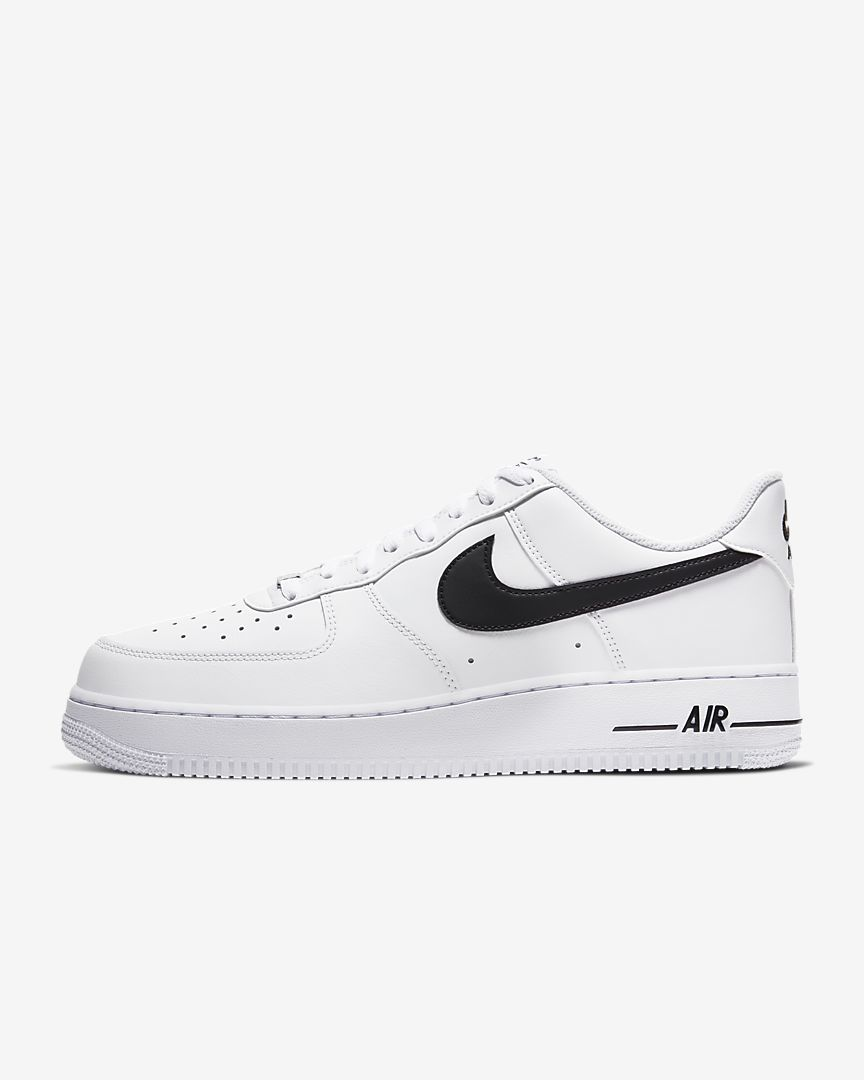

In [0]:
import IPython.display as display
display.display(display.Image(all_image_paths[0]))

In [0]:
def perprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    return image

In [0]:
all_images = [perprocess_image(x) for x in all_image_paths]
train_images = [perprocess_image(x) for x in train_image_paths]
test_images = [perprocess_image(x) for x in test_image_paths]

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)

image_ds = path_ds.map(perprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_image_ds = train_path_ds.map(perprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_image_ds = test_path_ds.map(perprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [0]:
# plt.figure(figsize=(8,8))
# for n, image in enumerate(image_ds.take(4)):
#   plt.subplot(2,2,n+1)
#   plt.imshow(image)
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])
#   plt.show()

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_labels, tf.int64))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_image_labels, tf.int64))

In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))

In [0]:
BATCH_SIZE = 32

ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
train_ds = train_image_label_ds.shuffle(buffer_size=image_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
test_ds = train_image_label_ds.shuffle(buffer_size=image_count)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(BATCH_SIZE)

test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
train_ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False

In [0]:
def change_range(image,label):
  return 2*image-1, label

In [0]:
keras_ds = ds.map(change_range)
train_keras_ds = train_ds.map(change_range)

In [0]:
image_batch, label_batch = next(iter(keras_ds))
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [0]:
train_image_batch, train_label_batch = next(iter(train_keras_ds))
feature_map_batch = mobile_net(train_image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [0]:
model = tf.keras.Sequential()
model.add(mobile_net)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(len(label_names), activation = 'softmax'))
  # tf.keras.layers.Conv2D(64, (3, 3), activation='softmax')])

In [0]:
logit_batch = model(image_batch).numpy()
train_logit_batch = model(train_image_batch).numpy()

print("min logit:", logit_batch.min(), train_logit_batch.min())
print("max logit:", logit_batch.max(), train_logit_batch.max())
print()

print("Shape:", logit_batch.shape, train_logit_batch.shape)

min logit: 0.026307955 0.015327586
max logit: 0.85593706 0.86232483

Shape: (32, 3) (32, 3)


In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [0]:
steps_per_epoch=tf.math.ceil(len(train_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

13.0

In [0]:
print(len(model.trainable_variables))
model.summary()

2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.fit(train_ds, epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
13/13 [==============================] - 2s 117ms/step - loss: 1.2059 - accuracy: 0.3630
Epoch 2/20
13/13 [==============================] - 1s 103ms/step - loss: 0.9176 - accuracy: 0.5649
Epoch 3/20
13/13 [==============================] - 1s 98ms/step - loss: 0.7148 - accuracy: 0.6875
Epoch 4/20
13/13 [==============================] - 1s 94ms/step - loss: 0.6195 - accuracy: 0.7452
Epoch 5/20
13/13 [==============================] - 1s 84ms/step - loss: 0.4627 - accuracy: 0.8486
Epoch 6/20
13/13 [==============================] - 1s 84ms/step - loss: 0.4733 - accuracy: 0.8293
Epoch 7/20
13/13 [==============================] - 2s 124ms/step - loss: 0.4060 - accuracy: 0.8798
Epoch 8/20
13/13 [==============================] - 1s 102ms/step - loss: 0.3950 - accuracy: 0.8846
Epoch 9/20
13/13 [==============================] - 1s 97ms/step - loss: 0.3441 - accuracy: 0.8918
Epoch 10/20
13/13 [==============================] - 1s 94ms/step - loss: 0.3092 - accuracy: 0.9255
Epoch

In [0]:
test_loss, test_acc = model.evaluate(test_ds, steps=steps_per_epoch)

print('\nTest accuracy:', test_acc)

13/13 [==============================] - 2s 147ms/step - loss: 1.0381 - accuracy: 0.5409

Test accuracy: 0.5408653616905212


In [0]:
classes = model.predict(test_ds, steps=steps_per_epoch)
print(classes[0])

[0.09765275 0.5647535  0.33759382]


In [0]:
print(test_ds[0])

TypeError: 'PrefetchDataset' object is not subscriptable

In [0]:
def _depthwise_separable_conv(inputs, num_pwc_filters, width_multiplier, sc, downsample=False):
    num_pwc_filters = round(num_pwc_filters * width_multiplier)
    _stride = 2 if downsample else 1

    # skip pointwise by setting num_outputs=None
    depthwise_conv = slim.separable_convolution2d(inputs, num_outputs=None, stride=_stride, 
                            depth_multiplier=1, kernel_size=[3, 3], scope=sc+'/depthwise_conv')

    bn = slim.batch_norm(depthwise_conv, scope=sc+'/dw_batch_norm')
    pointwise_conv = slim.convolution2d(bn, num_pwc_filters, kernel_size=[1, 1], scope=sc+'/pointwise_conv')
    bn = slim.batch_norm(pointwise_conv, scope=sc+'/pw_batch_norm')
    return bn